# Montecarlo Dropout
in this notebook we want implement mc dropout



In [2]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.config_builder import get_config




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC
data		   log	   pipeline_configs  requirements.txt  src
jupyter_notebooks  output  README.md	     shell_scripts     wandb


## Register Datasets

In [3]:
register_datasets()

registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset


## Train MC Dropout Model

In [12]:

!python ./src/pipeline_runner.py -f ./pipeline_configs/dropout_acdc_small_full_ds_local.yaml

registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset
running on server: False
/home/florian/GitRepos/activeCell-ACDC/src/train.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  wandb.config.update(yaml.load(cfg.dump()))
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if th

WARNING [12/02 13:30:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



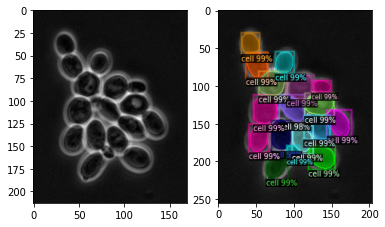

In [123]:
import os
from detectron2.engine import DefaultPredictor
cfg = get_config("dropout_acdc_small_full_ds_local")
logger = setup_logger(output="./log/main.log")
logger.setLevel(0)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
predictor = DefaultPredictor(cfg)
#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(get_dataset_name(ACDC_SMALL,TEST))[163]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

In [124]:
import torch
from itertools import chain 
from detectron2.checkpoint import DetectionCheckpointer

import detectron2.data.transforms as T
from baal.bayesian.dropout import patch_module

aug = T.ResizeShortestEdge(
        [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
with torch.no_grad():
    model = build_model(cfg)
    model = patch_module(model)
    model.eval()

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    

    height, width = im.shape[:2]
    image = aug.get_transform(im).apply_image(im)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = [{"image": image, "height": height, "width": width}]

    images = model.preprocess_image(inputs)
    features = model.backbone(images.tensor)


    proposals, _ = model.proposal_generator(images, features, None)
    features_ = [features[f] for f in model.roi_heads.box_in_features]

    box_features_pooler = model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
    prediction_list = []
    for _ in range(10):
        box_features = model.roi_heads.box_head(box_features_pooler)
        predictions = model.roi_heads.box_predictor(box_features)
        pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
        pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)
        
        outputs = model._postprocess(pred_instances, inputs, images.image_sizes)
        prediction_list.append(outputs)
    predictions_ = list(chain.from_iterable(prediction_list))


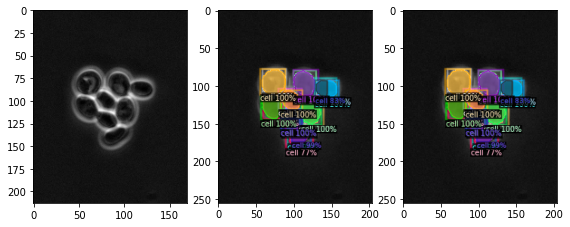

In [86]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out_1 = v.draw_instance_predictions(predictions_[1]["instances"].to("cpu"))
out_2 = v.draw_instance_predictions(predictions_[4]["instances"].to("cpu"))
show_image([im,out_1.get_image()[:, :, ::-1],out_2.get_image()[:, :, ::-1]])


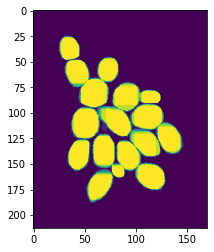

In [125]:
import numpy as np

masks = [np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in predictions_]


image_shape= masks[0][0].shape


images = []
for mask in masks:
    image = np.zeros(image_shape)

    for id in range(len(mask)):
        np.place(image, mask[id], 1)
    images.append(image)

images = np.array(images)

show_image(images.sum(axis=0), normalize=False)

In [126]:
def observations(outputs, iou_thres=0.5):
    """
    To cluster the segmentations for the different Monte-Carlo runs
    """
    observations = {}
    obs_id = 0

    for i in range(len(outputs)):
        sample = outputs[i]
        detections = len(sample['instances'])
        dets = sample['instances'].get_fields()
        
        for det in range(detections):
            if not observations:
                detection = {}
                for key, val in dets.items():
                    detection[key] = val[det]
                observations[obs_id] = [detection]

            else:
                addThis = None
                for group, ds, in observations.items():
                    for d in ds:
                        thisMask = dets['pred_masks'][det]
                        otherMask = d['pred_masks']
                        overlap = torch.logical_and(thisMask, otherMask)
                        union = torch.logical_or(thisMask, otherMask)
                        IOU = overlap.sum()/float(union.sum())
                        if IOU <= iou_thres:
                            break
                        else:
                            detection = {}
                            for key, val in dets.items():
                                detection[key] = val[det]
                            addThis = [group, detection]
                            break
                    if addThis:
                        break
                if addThis:
                    observations[addThis[0]].append(addThis[1])
                else:
                    obs_id += 1
                    detection = {}
                    for key, val in dets.items():
                        detection[key] = val[det]
                    observations[obs_id] = [detection]

    return observations

In [131]:
for key, val in observations(predictions_).items():
    print(key,val)
    softmaxes = [v['softmaxes'] for v in val]

0 [{'pred_boxes': Boxes(tensor([[ 57.7754, 121.6178,  81.2374, 156.5671]], device='cuda:0')), 'scores': tensor(0.9991, device='cuda:0'), 'pred_classes': tensor(0, device='cuda:0'), 'pred_masks': tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')}, {'pred_boxes': Boxes(tensor([[ 56.5466, 121.2646,  80.2715, 154.2113]], device='cuda:0')), 'scores': tensor(0.9968, device='cuda:0'), 'pred_classes': tensor(0, device='cuda:0'), 'pred_masks': tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, Fa

KeyError: 'softmaxes'

In [179]:
with open("model.txt", "w") as file:
    file.write(str(model))

In [23]:

with torch.no_grad():
    
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    preds = model([inputs])[0]


TypeError: list indices must be integers or slices, not str

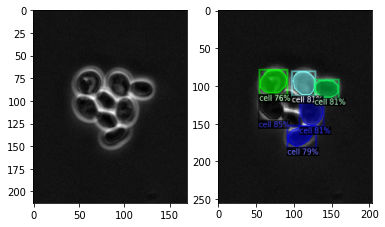

In [20]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(preds[0]["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

In [12]:
preds

[{'instances': Instances(num_instances=6, image_height=213, image_width=170, fields=[pred_boxes: Boxes(tensor([[ 44.6536,  93.8623,  71.7391, 122.4590],
          [ 90.3478,  96.8985, 116.4053, 129.1191],
          [ 81.8581,  68.2022, 107.4844,  94.9468],
          [106.3665,  77.3985, 133.6780,  97.7313],
          [ 76.5940, 127.8458, 108.5142, 152.2145],
          [ 45.8551,  66.1485,  76.4062,  93.6909]], device='cuda:0',
         grad_fn=<IndexBackward0>)), scores: tensor([0.8534, 0.8124, 0.8077, 0.8055, 0.7875, 0.7629], device='cuda:0',
         grad_fn=<IndexBackward0>), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False

In [13]:
predictions_

[{'instances': Instances(num_instances=6, image_height=213, image_width=170, fields=[pred_boxes: Boxes(tensor([[ 44.6536,  93.8625,  71.7395, 122.4588],
          [ 90.3469,  96.8985, 116.4046, 129.1195],
          [ 81.8578,  68.2015, 107.4853,  94.9475],
          [106.3663,  77.3986, 133.6778,  97.7314],
          [ 76.5931, 127.8455, 108.5149, 152.2160],
          [ 45.8555,  66.1483,  76.4068,  93.6906]], device='cuda:0')), scores: tensor([0.8534, 0.8123, 0.8077, 0.8055, 0.7874, 0.7629], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],
  
          [[False, False, Fal